In [18]:
%cd protein_bert
# !git submodule init
# !git submodule update
# !python setup.py install

[Errno 2] No such file or directory: 'protein_bert'
/Users/qiaochufeng/Documents/GitHub/DS596-Project/protein_bert


In [19]:
BENCHMARKS_DIR = '/protein_benchmarks'
BENCHMARK_NAME = 'signalP_binary'

import os
import pandas as pd
from IPython.display import display
from tensorflow import keras
from sklearn.model_selection import train_test_split
from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, finetune, evaluate_by_len
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs

MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK 0


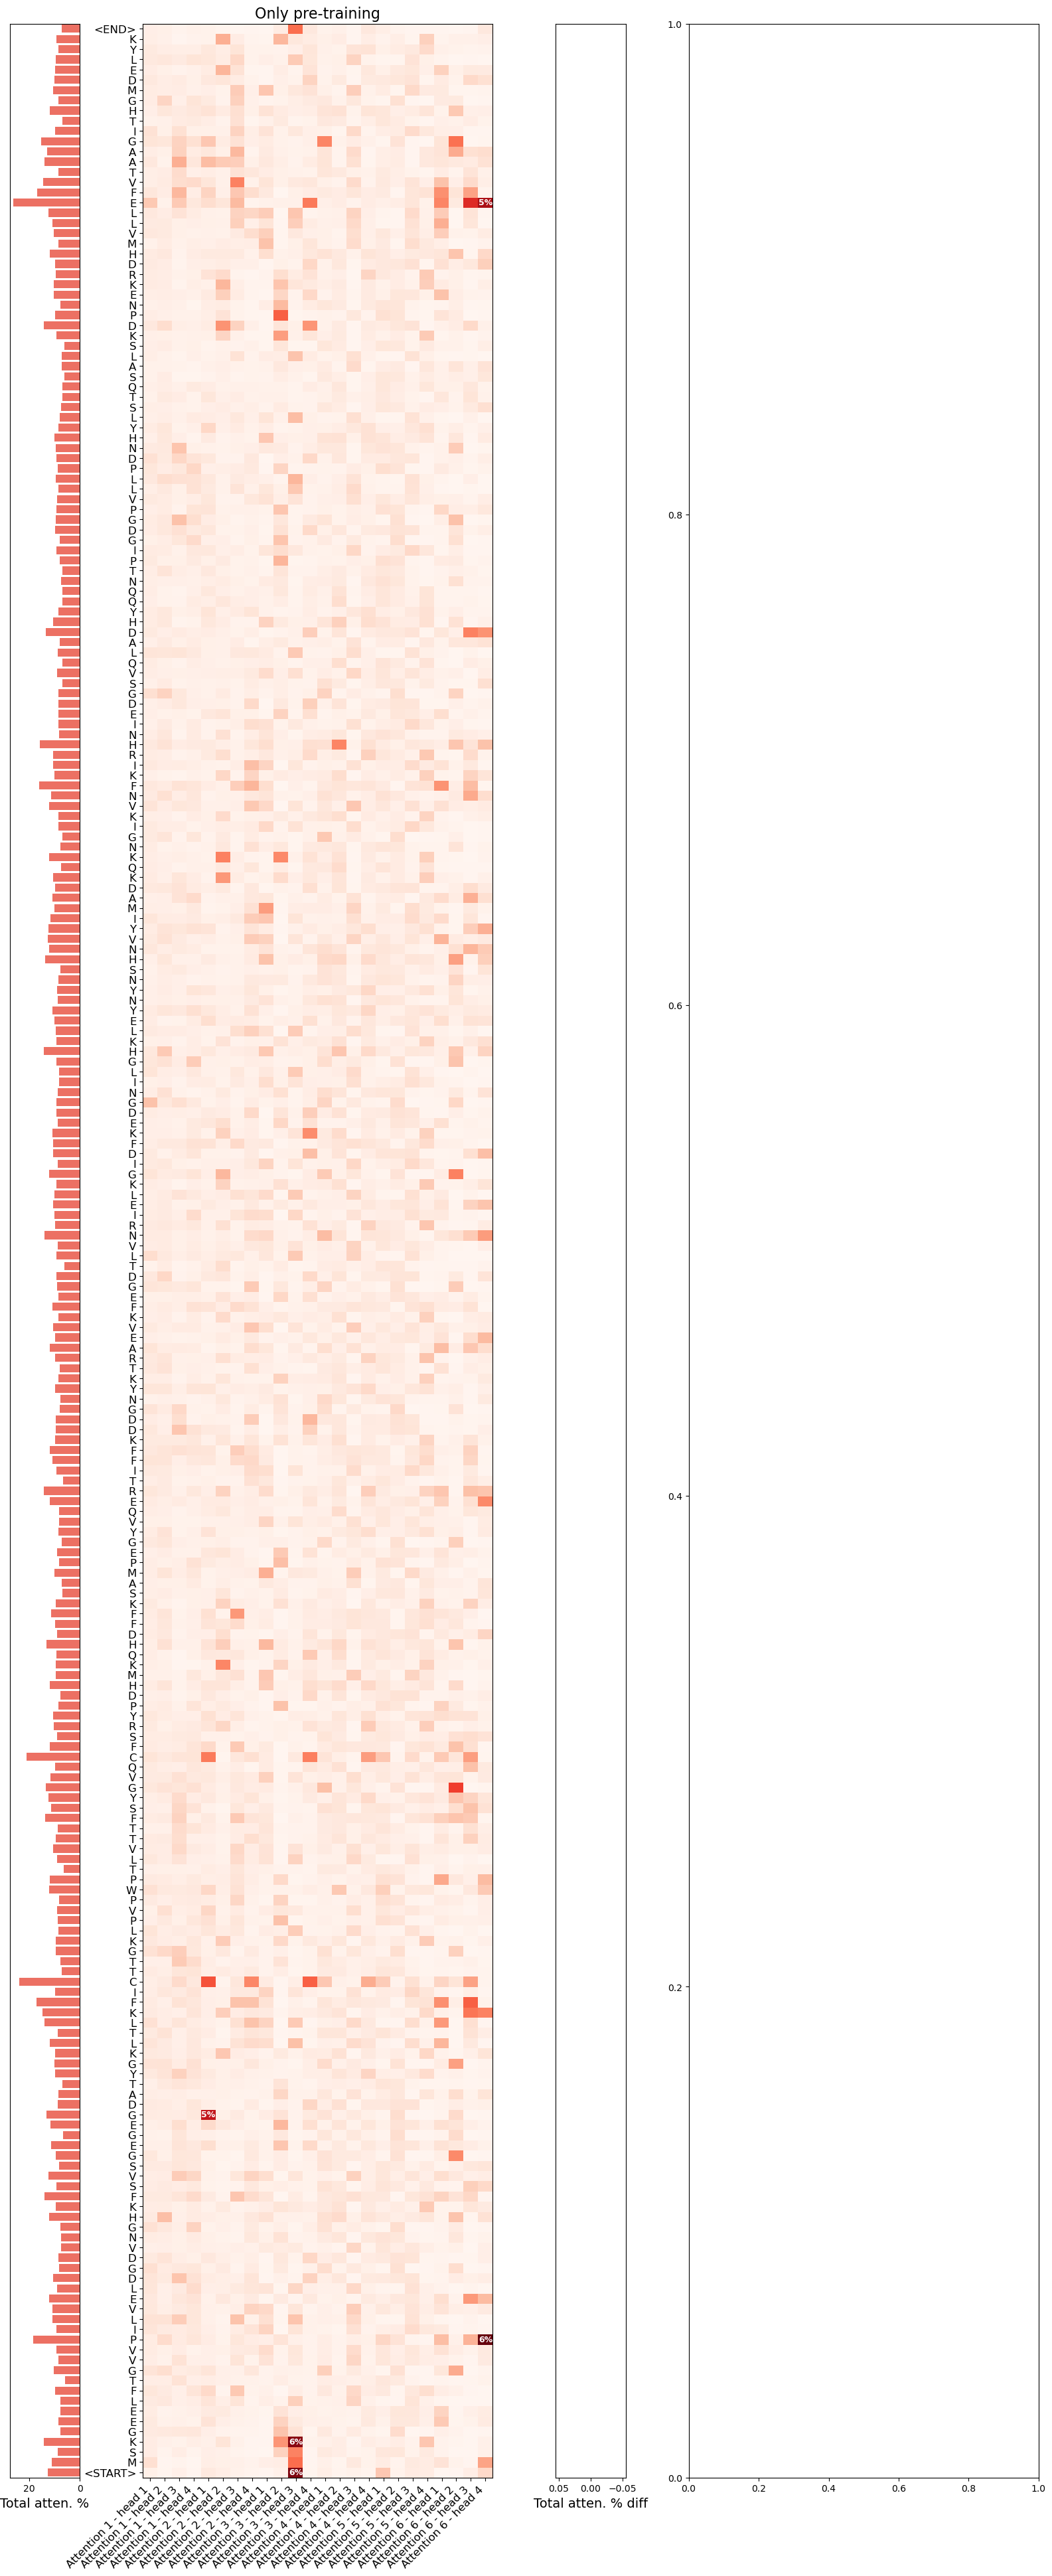

In [20]:
import numpy as np
import matplotlib.pyplot as plt

BENCHMARK_DISPLAY_NAME = 'Signal peptide'

TEST_SET_FILE_PATH = './protein_benchmarks/signalP_binary.train.csv'
IDEAL_LEN = 80

def calculate_attentions(model, input_encoder, seq, seq_len = None):
    
    from tensorflow.keras import backend as K
    from proteinbert.tokenization import index_to_token
    
    if seq_len is None:
        seq_len = len(seq) + 2
    
    X = input_encoder.encode_X([seq], seq_len)
    (X_seq,), _ = X
    seq_tokens = list(map(index_to_token.get, X_seq))

    model_inputs = [layer.input for layer in model.layers if 'InputLayer' in str(type(layer))][::-1]
    model_attentions = [layer.calculate_attention(layer.input) for layer in model.layers if 'GlobalAttention' in str(type(layer))]
    invoke_model_attentions = K.function(model_inputs, model_attentions)
    attention_values = invoke_model_attentions(X)
    
    attention_labels = []
    merged_attention_values = []

    for attention_layer_index, attention_layer_values in enumerate(attention_values):
        for head_index, head_values in enumerate(attention_layer_values):
            attention_labels.append('Attention %d - head %d' % (attention_layer_index + 1, head_index + 1))
            merged_attention_values.append(head_values)

    attention_values = np.array(merged_attention_values)
    
    return attention_values, seq_tokens, attention_labels

def plot_attention(attention_values, seq_tokens, attention_labels, ax, cmap = 'Reds', vmin = 0, vmax = None, text_value_threshold = 0.1):

    heatmap = ax.pcolor(attention_values.transpose(), cmap = cmap, vmin = vmin, vmax = vmax)

    ax.set_xticks(np.arange(len(attention_labels)) + 0.5)
    ax.set_xticklabels(attention_labels, rotation = 45, ha = 'right', fontsize = 12)
    ax.set_yticks(np.arange(len(seq_tokens)) + 0.5)
    ax.set_yticklabels(seq_tokens, fontsize = 12)

    for i, row in enumerate(attention_values):
        for j, value in enumerate(row):
            if abs(value) >= text_value_threshold:
                add_plus_sign = attention_values.min() < 0 and value > 0
                plus_sign = '+' if add_plus_sign else ''
                ax.text(i + 0.5, j + 0.5, plus_sign + '%d%%' % (100 * value), color = 'white', ha = 'center', va = 'center', \
                        fontsize = 9, fontweight = 'bold', fontstretch = 'condensed')
                
test_set = pd.read_csv(TEST_SET_FILE_PATH)
chosen_index = ((test_set['seq'].str.len() - IDEAL_LEN).abs()).sort_values().index[0]
# seq = test_set.loc[chosen_index, 'seq']
# label = test_set.loc[chosen_index, 'label']

seq = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'
label = 0
                
seq_len = len(seq) + 2

pretrained_model_generator, input_encoder = load_pretrained_model()
model = pretrained_model_generator.create_model(seq_len)
pretrained_attention_values, pretrained_seq_tokens, pretrained_attention_labels = calculate_attentions(model, input_encoder, seq, \
        seq_len = seq_len)

model = pretrained_model_generator.create_model(seq_len)
finetuned_attention_values, finetuned_seq_tokens, finetuned_attention_labels = calculate_attentions(model, input_encoder, seq, \
        seq_len = seq_len)
assert finetuned_seq_tokens == pretrained_seq_tokens
assert finetuned_attention_labels == pretrained_attention_labels[:len(finetuned_attention_labels)]

fig, axes = plt.subplots(ncols = 4, figsize = (20, 0.2 * seq_len), gridspec_kw = dict(width_ratios = [1, 5, 1, 5]))
fig.subplots_adjust(wspace = 0.3)

axes[0].barh(np.arange(seq_len), 100 * pretrained_attention_values.sum(axis = 0), color = '#EC7063')
axes[0].set_ylim((-0.5, seq_len - 0.5))
axes[0].set_yticks([])
axes[0].invert_xaxis()
axes[0].set_xlabel('Total atten. %', fontsize = 14)

vmax = pretrained_attention_values.max()
plot_attention(pretrained_attention_values, pretrained_seq_tokens, pretrained_attention_labels, axes[1], cmap = 'Reds', vmax = vmax, \
        text_value_threshold = 0.05)
axes[1].set_title('Only pre-training', fontsize = 16)

axes[2].barh(np.arange(seq_len), 100 * (finetuned_attention_values - pretrained_attention_values).sum(axis = 0), color = '#28B463')
axes[2].set_ylim((-0.5, seq_len - 0.5))
axes[2].set_yticks([])
axes[2].invert_xaxis()
axes[2].set_xlabel('Total atten. % diff', fontsize = 14)

attention_diff = finetuned_attention_values - pretrained_attention_values[:len(finetuned_attention_labels), :]
vmax = np.abs(attention_diff).max()
# plot_attention(attention_diff, finetuned_seq_tokens, finetuned_attention_labels, axes[3], cmap = 'PiYG', vmin = -vmax, vmax = vmax, \
#         text_value_threshold = 0.03)
# axes[3].set_title('%s fine-tuning' % BENCHMARK_DISPLAY_NAME, fontsize = 16)

print(seq, label)

In [25]:
seq[157:]

'KNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'

In [24]:
seq

'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'

In [ ]:
head_view(pretrained_attention_values, pretrained_seq_tokens, pretrained_attention_labels)

In [16]:
def calculate_full_attentions(model, input_encoder, seq, seq_len=None):
    from tensorflow.keras import backend as K
    from proteinbert.tokenization import index_to_token
    import tensorflow as tf

    if seq_len is None:
        seq_len = len(seq) + 2

    X = input_encoder.encode_X([seq], seq_len)
    (X_seq,), _ = X
    seq_tokens = list(map(index_to_token.get, X_seq))

    # 创建一个新的模型，输出注意力权重
    attention_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.MultiHeadAttention)]
    attention_outputs = []
    outputs = X_seq

    # 创建输入张量
    inputs = model.input

    # 收集所有注意力层的输出
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.MultiHeadAttention):
            # 将注意力层的输出（包括注意力权重）添加到列表中
            # 注意：需要确保 MultiHeadAttention 层设置了 return_attention_scores=True
            outputs, attn_scores = layer(outputs, outputs, return_attention_scores=True)
            attention_outputs.append(attn_scores)
        else:
            outputs = layer(outputs)

    # 将 attention_outputs 转换为张量列表
    attention_outputs = [attn for attn in attention_outputs]

    # 创建一个新的 Keras 模型，输出注意力权重
    attention_model = tf.keras.Model(inputs=inputs, outputs=attention_outputs)

    # 获取注意力矩阵
    attentions = attention_model.predict(X)

    # 将 attentions 转换为 numpy 数组，并调整形状
    # attentions 是一个列表，每个元素形状为 (batch_size, num_heads, seq_len, seq_len)
    attention_matrices = np.array([att[0] for att in attentions])  # 移除 batch_size 维度

    # 最终的 attention_matrices 形状应为 (num_layers, num_heads, seq_len, seq_len)
    return attention_matrices, seq_tokens


In [17]:
from bertviz import head_view

# 假设 attention_matrices 的形状为 [num_layers, num_heads, seq_len, seq_len]
attention_matrices, seq_tokens = calculate_full_attentions(model, input_encoder, seq, seq_len=seq_len)

# 使用 BertViz 进行可视化
head_view(attention=attention_matrices, tokens=seq_tokens)


ValueError: Input 0 of layer "dense-global-input" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (72,)

In [12]:
attention_matrices, seq_tokens = calculate_full_attentions(model, input_encoder, seq, seq_len=seq_len)
print("Attention matrices shape:", attention_matrices.shape)
# 应输出 (num_layers, num_heads, seq_len, seq_len)


IndexError: list index out of range

In [13]:
print("Attention outputs:", attention_outputs)


NameError: name 'attention_outputs' is not defined